# Modeling

In [439]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
import scipy.stats as stats
import pylab as py

In [440]:
sumo_df = pd.read_csv('../data/sumo_premodel_df.csv')

In [441]:
sumo_df.head()

,id,sumodb_id,nsk_id,ring_name,current_rank,height,weight,total_wins,total_losses,total_matches,rank_group,age,win_rate,debut_year,tenure,ichimon
0,7522,10438,0,Hakushuzan,Retired,0.0,0.0,27,36,63,4,0,42.86,1954,5,Unaffilliated
1,2973,5772,0,Wakahokkai Gentaro,Retired,0.0,0.0,146,160,306,4,81,47.71,1959,7,Unaffilliated
2,6428,6679,0,Kakuryuasahi,Retired,178.5,111.0,26,23,49,4,53,53.06,1987,1,Isegahama
3,3683,381,0,Katsumayama Shuichi,Retired,177.0,113.5,223,211,434,4,46,51.38,1994,11,Nishonoseki
4,6560,7299,0,Otsuru,Retired,186.0,77.0,78,73,151,4,57,51.66,1983,4,Nishonoseki


## Table of Contents
- [Outliers](#Outliers)
- [Age Modeling](#Age-Modeling)
- [Predict Rikishi Ages: Linear Regression](#Predict-Rikishi-Ages:-Linear-Regression)
- [Weight Modeling](#Weight-Modeling)
- [Height Modelng](#Height-Modeling)


## Outliers

### As I was working with the data, I discovered outliers that I believe to be occuring due to incorrect original data.  This section is to address outliers in an attempt to make the modeling process more accurate.

#### Tenure - Some of the rikishi have very long tenure years.  I was able to verify that some of the retirement years were incorrect via the Sumodb website.  I will drop any rikishi that have tenure years over 40.

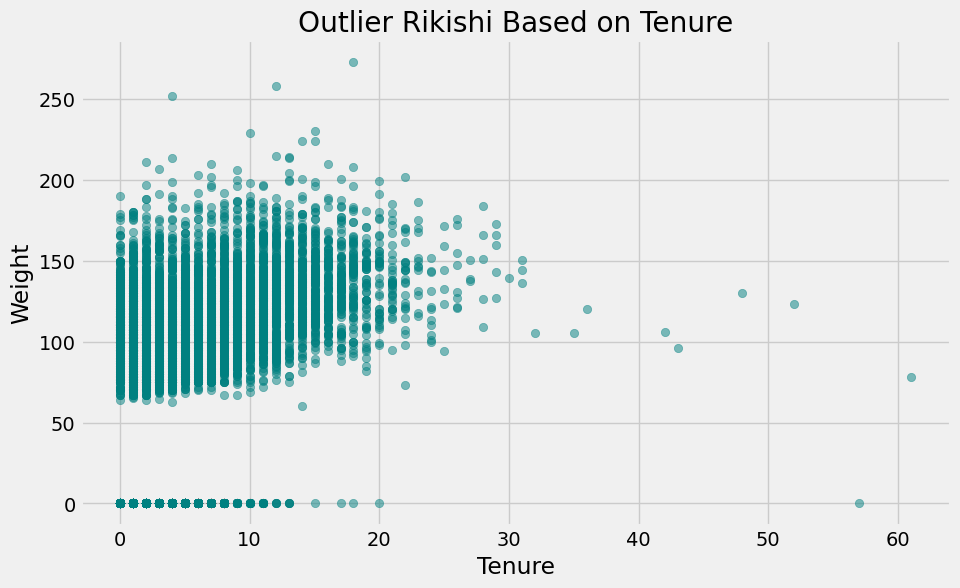

In [442]:
plt.figure(figsize=(10,6))

plt.xlabel('Tenure')
plt.ylabel('Weight')
plt.title('Outlier Rikishi Based on Tenure');

plt.scatter(x = sumo_df['tenure'], y = sumo_df['weight'], alpha = 0.5, color = 'teal');

In [443]:
# Only keep rikishi who have a tenure of less than 40 years
sumo_df = sumo_df[sumo_df['tenure'] < 40]

## Age Modeling

#### 13% of the dataset does not have valid ages.  The goal is to use a model to predict the ages instead of imputing a mean or mode as that would be less accurate.  Some of the rikishi in this set have passed on, but I will keep their projected ages for the sake of modeling.

In [444]:
sumo_df['age'].value_counts(normalize = True) * 100

age
0      12.906673
48      2.220375
47      2.101639
51      1.935407
46      1.887913
         ...    
102     0.071242
15      0.035621
103     0.023747
104     0.011874
105     0.011874
Name: proportion, Length: 92, dtype: float64

#### Using linear regression to predict age based on rikishi's debut year looks like a good method.  They have a linear relationship according to the plot below, but it also shows points that are missing age data.

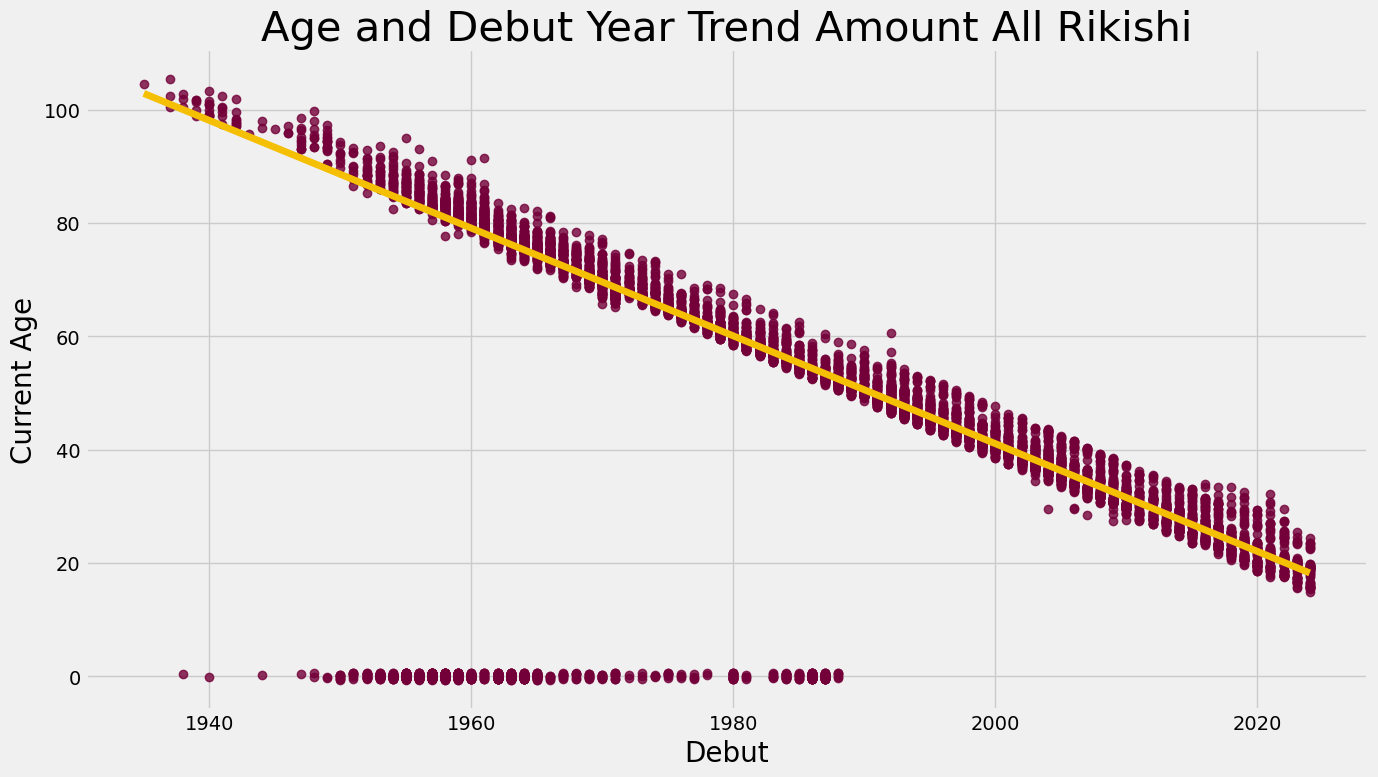

In [445]:
plt.figure(figsize = (14, 8))
plt.style.use('fivethirtyeight')


plt.title('Age and Debut Year Trend Amount All Rikishi',
         size = 30)

plt.xlabel('Debut', size = 20)

sns.regplot(data = sumo_df,
            x = 'debut_year',
            y = 'age',
            ci = None,
            y_jitter = .60,
            scatter_kws={'color':'xkcd:merlot'},
            line_kws={'lw': 5, 'color':'xkcd:golden'},
            robust = True)

plt.xlabel('Debut', size = 20)
plt.ylabel('Current Age', size = 20)

plt.tight_layout()
# plt.savefig('../plots/active_rikisi_age_vs_debut.png', dpi = 192);

### Linear Regression - Using Debut Year to Predict Age

#### Make two tables, one where every rikishi has a valid age and one where every rikishi's age equals 0.

In [446]:
age_sumo_df = sumo_df[sumo_df['age'] != 0]
no_age_sumo_df  = sumo_df[sumo_df['age'] == 0].copy()

#### Use the age_sumo_df to model with. Once the model is created, predict ages on the no_age_sumo_df data.

In [447]:
X = age_sumo_df[['debut_year']]
y = age_sumo_df['age']

In [448]:
# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 24)

#### Basline Model and Trying out LinearRegression!

In [449]:
#Basline model as the mean
y_bar = np.mean(y_test)

#### Baseline model is 18.6 years.

In [450]:
print(f'Null Mean Squared Error: {np.mean((y - y_bar)**2)}')
print(f'Null Root Mean Squared Error: {np.sqrt(np.mean((y - y_bar)**2))}')

Null Mean Squared Error: 344.34365607853545
Null Root Mean Squared Error: 18.556499025369398


In [451]:
lr = LinearRegression()

In [452]:
lr.fit(X_train, y_train)

LinearRegression()

#### Linear Regression Metrics for Age Prediction 

In [453]:
# R2 values for training and testing scores.  This looks decent and not overfit.
print(f'Training R-Squared Score: {lr.score(X_train, y_train)}')
print(f'Testing R-Squred Score: {lr.score(X_test, y_test)}')

Training R-Squared Score: 0.9884782928871079
Testing R-Squred Score: 0.9884002184470484


In [454]:
scores = cross_val_score(lr, X_train, y_train, cv=5)

# Step 4: Print the cross-validation scores
print("Train Cross-Validation Scores: ", scores)
print("Train Mean Cross-Validation Score: ", scores.mean())

Train Cross-Validation Scores:  [0.98743175 0.98907908 0.98753861 0.98939867 0.98883721]
Train Mean Cross-Validation Score:  0.9884570640726519


In [455]:
scores = cross_val_score(lr, X_test, y_test, cv=5)

# Step 4: Print the cross-validation scores
print("Test Cross-Validation Scores: ", scores)
print("Test Mean Cross-Validation Score: ", scores.mean())

Test Cross-Validation Scores:  [0.98973633 0.98804902 0.98557921 0.98940974 0.98862474]
Test Mean Cross-Validation Score:  0.988279807323412


#### Apply model to test data and create age residuals variable

In [456]:
# Predictions on training data and calculating residuals
y_pred = lr.predict(X_test)
resids = y_test - y_pred

#### A RMSE of 2.0 is a big improvement over 18.6

In [457]:
print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred)}')
print(f'Root Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred, squared = False)}')

Mean Squared Error: 4.083639178828837
Root Mean Squared Error: 2.0208016178805965


#### LINE Assumptions
- L: There is a linear relationship betweeen a rikishi's age and their debut year as visualized in the above plot.
- I: There could be a break here because I am not sure if the average age for a new rikishi has changed over time.
- N: The residuals are <b>not</b> normal.  The plot is right skewed, which indicates that most rikishi debut at younger ages.
- E: There is no equal variance of residuals

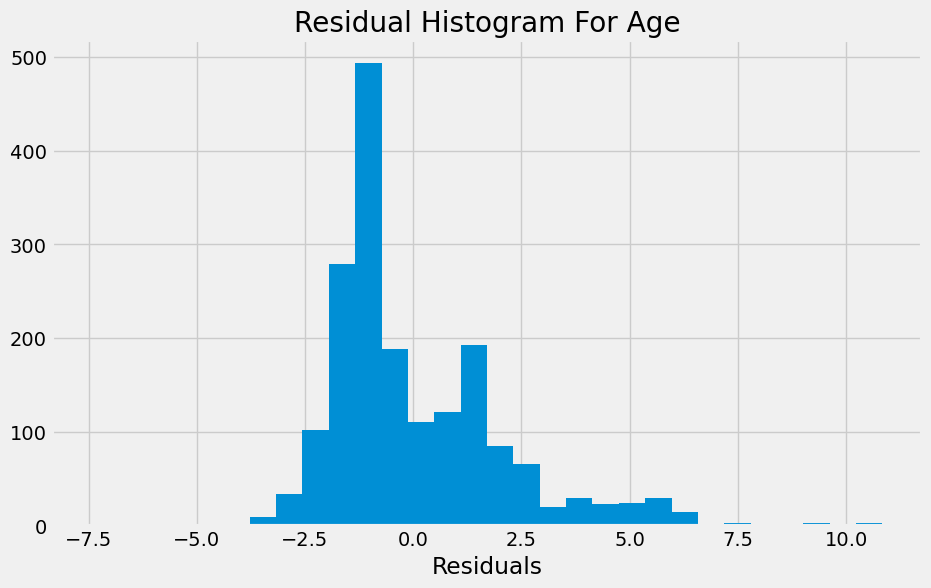

In [458]:
plt.figure(figsize=(10, 6))
plt.hist(resids, bins = 30)
plt.xlabel('Residuals')
plt.title('Residual Histogram For Age');

<Figure size 1000x600 with 0 Axes>

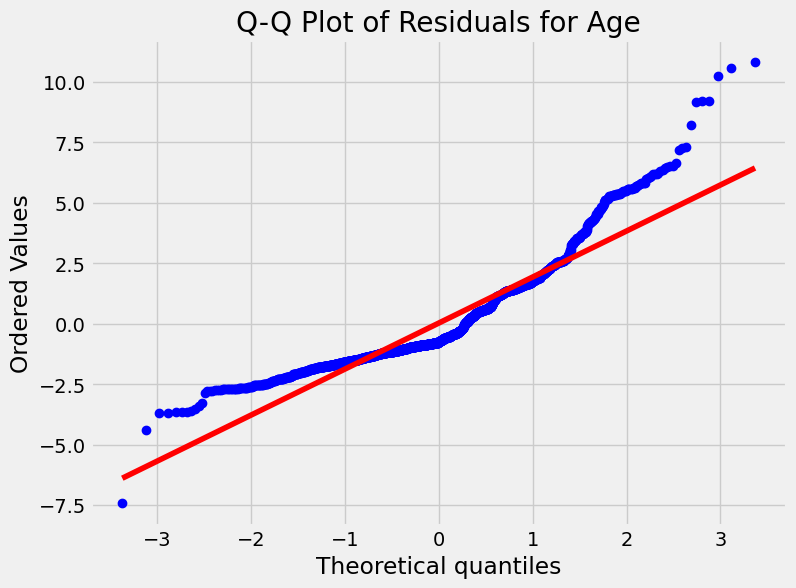

In [459]:
plt.figure(figsize=(10,6))
plt.figure(figsize=(8, 6))
stats.probplot(resids, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals for Age')
plt.show()

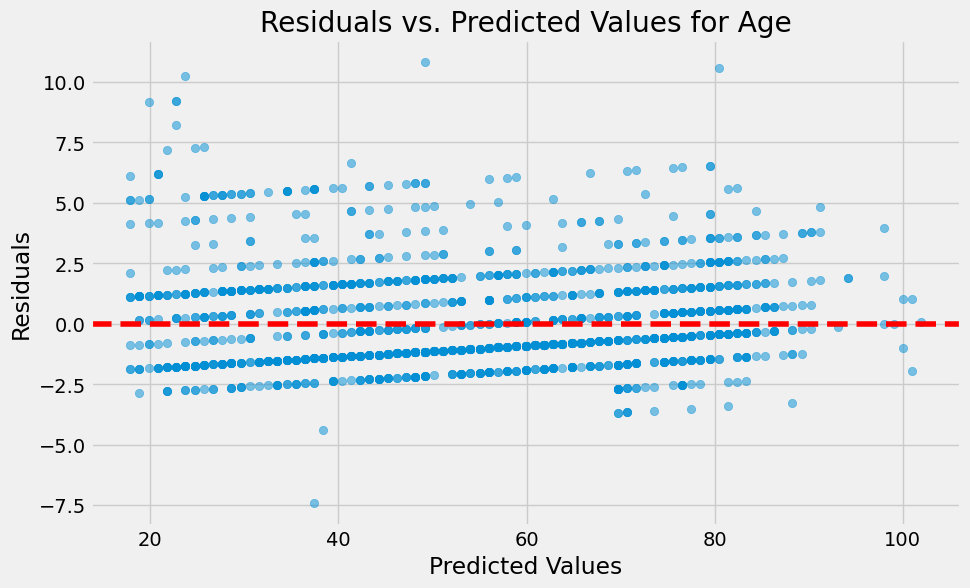

In [460]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, resids, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values for Age')
plt.axhline(y=0, color='r', linestyle='--')

### Random Forest Model

#### Trying out Random Forest as an alternate model since linear model doesn't pass LINE assumption.  Both do equally well.

In [461]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [462]:
scores = cross_val_score(rf, X_train, y_train, cv=5)

# Step 4: Print the cross-validation scores
print("Train Cross-Validation Scores: ", scores)
print("Mean Train Cross-Validation Score: ", scores.mean())

Train Cross-Validation Scores:  [0.98819693 0.98950305 0.98850462 0.99034901 0.98949601]
Mean Train Cross-Validation Score:  0.9892099241010994


In [463]:
scores = cross_val_score(rf, X_test, y_test, cv=5)

# Step 4: Print the cross-validation scores
print("Test Cross-Validation Scores: ", scores)
print("Mean Test Cross-Validation Score: ", scores.mean())

Test Cross-Validation Scores:  [0.98968985 0.98741683 0.98611069 0.98888626 0.98920982]
Mean Test Cross-Validation Score:  0.9882626898839023


### Predict Rikishi Ages

In [464]:
# Drop the age column from the no_age_sumo_df dataframe. A column will be added that includes the predicted ages to replace it.
no_age_sumo_df.drop(columns = ['age'], inplace = True)

In [465]:
# Create a new dataframe with the debut years of all rikishi from the no_age_sumo_df.  This column will be the 'X' value to predict age.
unseen_age_df = no_age_sumo_df[['debut_year']]

In [466]:
no_age_sumo_df['age_predicted'] = lr.predict(unseen_age_df).astype(int)

### Age Coefficient
#### As the year increases, the age decreases by about one year

In [467]:
age_coefficients = lr.coef_
print('Age Coefficient: ', age_coefficients)

Age Coefficient:  [-0.9773767]


### Add Predicted Ages to Sumo Dataframe

In [468]:
# This works because the indexing between the two dataframes remained the same.  The mask is TRUE
# when 'age' is 0.  If true, the value will be updated with the 'age_predicted' value at the same index
# in no_age_sumo_df.

mask = sumo_df['age'] == 0
sumo_df.loc[mask, 'age'] = no_age_sumo_df.loc[mask, 'age_predicted']

## Exploring Height and Weight Modeling

#### It looks like for all missing height and weight values, they are missing as pairs. 1839 observations total are missing this information."

In [469]:
sumo_df['weight'].value_counts()

weight
0.0      1838
100.0     153
110.0     135
75.0      126
105.0     120
         ... 
135.1       1
156.9       1
162.2       1
148.4       1
109.6       1
Name: count, Length: 672, dtype: int64

In [470]:
sumo_df['height'].value_counts()

height
0.0      1838
173.0     425
175.0     384
178.0     369
174.0     367
         ... 
186.2       1
173.1       1
186.3       1
174.7       1
160.0       1
Name: count, Length: 211, dtype: int64

In [471]:
# check how many rows where height and weight are both zero and see if it matches 1839
sumo_df[(sumo_df['height'] == 0) & (sumo_df['weight'] == 0)].shape[0]


1838

#### All except one rikishi with missing height and weight data are retired.  Don't think it's practical to use rank to predict weight.

In [472]:
# Create a table that only contains observations where height and weight data are missing

missinghw_df = sumo_df[(sumo_df['height'] == 0) & (sumo_df['weight'] == 0)].copy()
missinghw_df['current_rank'].value_counts()

current_rank
Retired     1837
Sandanme       1
Name: count, dtype: int64

#### Create a mask for rows where height and weight are missing so they can be dropped and complete data can be explored.

In [473]:
heightweight_mask = (sumo_df['height'] == 0) & (sumo_df['weight'] == 0)

In [474]:
# Create a database where observations missing height and weight data are dropped

heightweight_df = sumo_df[~heightweight_mask]

In [475]:
heightweight_df.head()

,id,sumodb_id,nsk_id,ring_name,current_rank,height,weight,total_wins,total_losses,total_matches,rank_group,age,win_rate,debut_year,tenure,ichimon
2,6428,6679,0,Kakuryuasahi,Retired,178.5,111.0,26,23,49,4,53,53.06,1987,1,Isegahama
3,3683,381,0,Katsumayama Shuichi,Retired,177.0,113.5,223,211,434,4,46,51.38,1994,11,Nishonoseki
4,6560,7299,0,Otsuru,Retired,186.0,77.0,78,73,151,4,57,51.66,1983,4,Nishonoseki
5,2954,4235,0,Banryunada Kenzo,Retired,173.0,83.0,162,167,329,4,87,49.24,1953,12,Dewanoumi
7,6531,7381,0,Onakajima,Retired,176.0,95.0,14,21,35,4,55,40.00,1985,1,Unaffilliated


#### Make a heatmap to observe which features are correlated with height and weight

Text(0.5, 1.0, 'Sumo Data Heatmap')

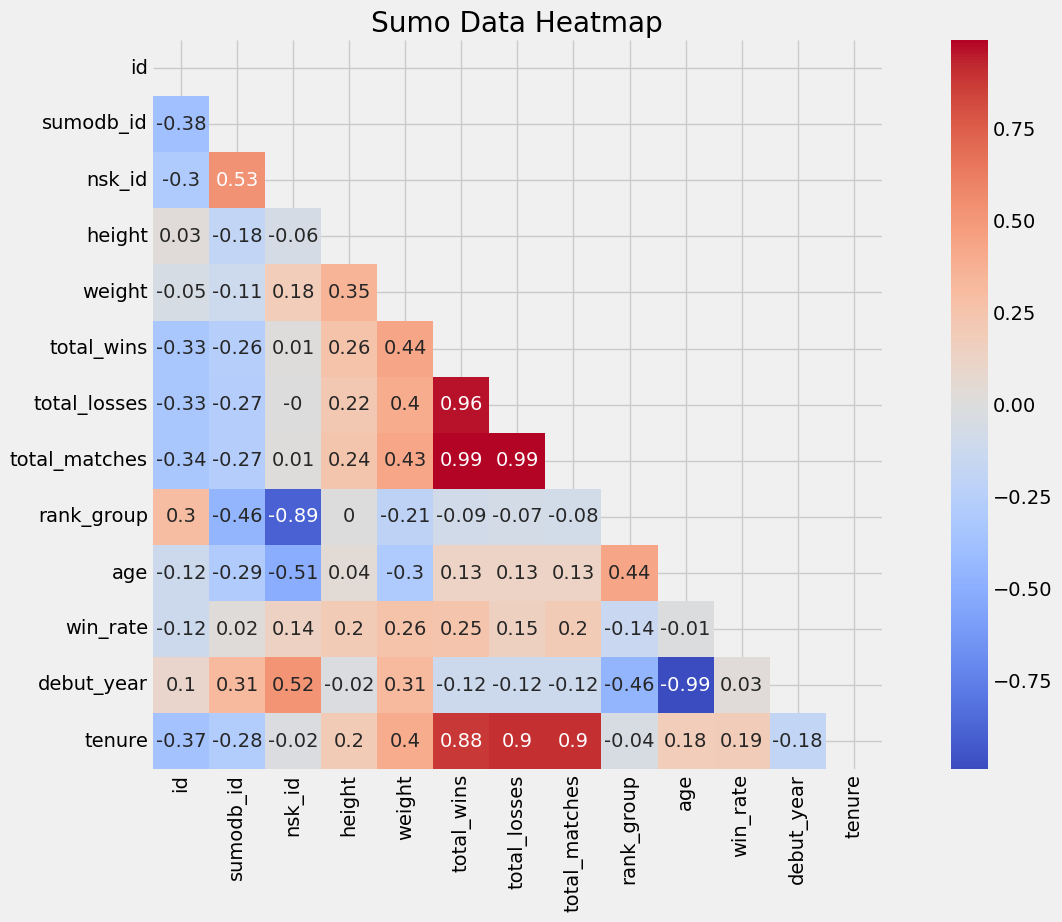

In [476]:
# Create a heatmap to observe correlations between height, weight, and other features.
plt.figure(figsize = (16,9))

corr = round(heightweight_df.corr(numeric_only=True), 2)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
            square = True,
            annot = True,
            cmap = 'coolwarm',
            mask = mask);

plt.title('Sumo Data Heatmap')

#### I will try to model weight first as there looks to be more features correlated to it such as:
- Tenure
- Debut Year
- Age
- Total Matches

#### Once I have weights, I can use that along with other features to predict height.  Weight happens to be the highest correlated feature for height.

## Weight Modeling

### Linear Regression - Using a variety of features to predict weight.

In [477]:
# Create X features and y value to predict

X = heightweight_df[['tenure','debut_year', 'age', 'total_matches']]
y = heightweight_df['weight']

In [478]:
# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 24)

In [479]:
#Basline model as the mean
y_bar = np.mean(y_test)

#### Baseline model is 25.4 kg or 58.2 pounds

In [480]:
print(f'Null Mean Squared Error: {np.mean((y - y_bar)**2)}')
print(f'Null Root Mean Squared Error: {np.sqrt(np.mean((y - y_bar)**2))}')

Null Mean Squared Error: 696.882026087027
Null Root Mean Squared Error: 26.398523180038445


In [481]:
# Weight Linear Regression Pipeline

weight_lr_pipeline = Pipeline([
    ('polynom_features', PolynomialFeatures(degree = 2)),
    ('sc', StandardScaler()),
    ('weight_lr', LinearRegression())
])

In [482]:
weight_lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('polynom_features', PolynomialFeatures()),
                ('sc', StandardScaler()), ('weight_lr', LinearRegression())])

In [483]:
y_pred = weight_lr_pipeline.predict(X_test)

#### Linear Regression Metrics For Weight Prediction

In [484]:
# R Squared
print(f'Training R-Squared Score: {weight_lr_pipeline.score(X_train, y_train)}')
print(f'Testing R-Squred Score: {weight_lr_pipeline.score(X_test, y_test)}')

Training R-Squared Score: 0.3697320696435247
Testing R-Squred Score: 0.3791945677509634


In [485]:
# Train Cross Validation
scores = cross_val_score(weight_lr_pipeline, X_train, y_train, cv=5)

# Step 4: Print the cross-validation scores
print("Train Cross-Validation Scores: ", scores)
print("Train Mean Cross-Validation Score: ", scores.mean())

Train Cross-Validation Scores:  [0.36013313 0.38196639 0.35734652 0.36459672 0.35240854]
Train Mean Cross-Validation Score:  0.3632902611839949


In [486]:
#Test Cross Validation

scores = cross_val_score(weight_lr_pipeline, X_test, y_test, cv=5)

# Step 4: Print the cross-validation scores
print("Test Cross-Validation Scores: ", scores)
print("Test Mean Cross-Validation Score: ", scores.mean())

Test Cross-Validation Scores:  [0.36937166 0.38331556 0.40125727 0.39421738 0.32336112]
Test Mean Cross-Validation Score:  0.37430459911067604


#### A RMSE of 20.7 kg is a slight improvement over 25.4 kg (58.2 poundds vs 47.6)

In [487]:
print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred)}')
print(f'Root Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred, squared = False)}')

Mean Squared Error: 428.6660763264747
Root Mean Squared Error: 20.704252614534887


### Residual Plots - Interpretability is lost with polynomial features, but helpful to check residual behavior)

In [488]:
resids = y_test - y_pred

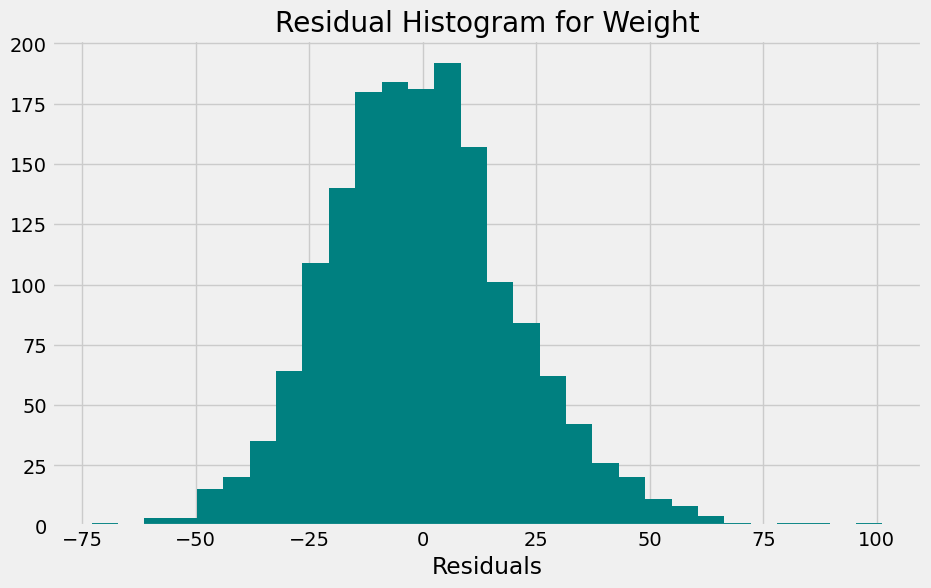

In [489]:
plt.figure(figsize=(10, 6))
plt.hist(resids, bins = 30, color = 'teal')
plt.xlabel('Residuals')
plt.title('Residual Histogram for Weight');

<Figure size 1000x600 with 0 Axes>

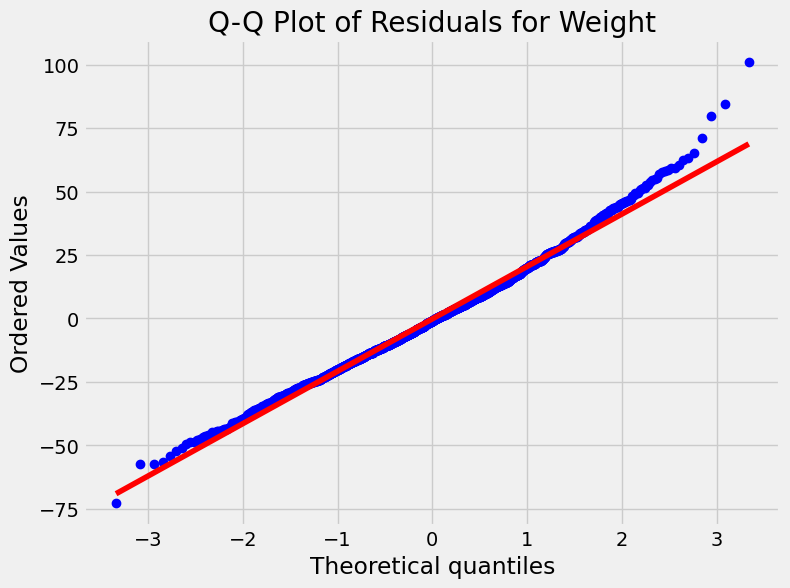

In [490]:
plt.figure(figsize=(10,6))
plt.figure(figsize=(8, 6))
stats.probplot(resids, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals for Weight')
plt.show()

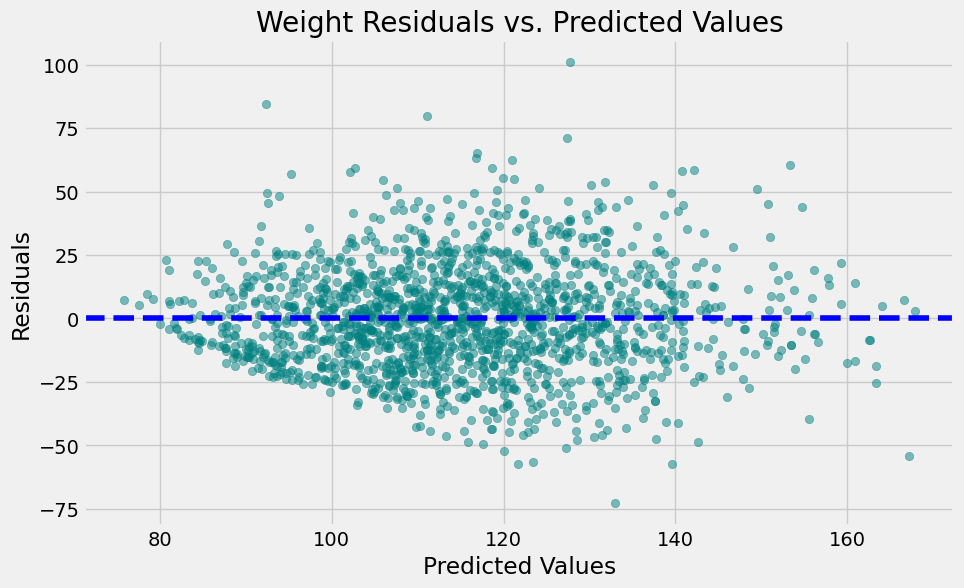

In [491]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, resids, alpha=0.5, color = 'teal')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Weight Residuals vs. Predicted Values')
plt.axhline(y=0, color='b', linestyle='--')

### Random Forest Model

In [492]:
weight_rf_pipeline = Pipeline([
    ('polynom_features', PolynomialFeatures(degree = 2)),
    ('sc', StandardScaler()),
    ('weight_rf', RandomForestRegressor())
])

In [493]:
weight_rf_params = {
    'weight_rf__n_estimators': [200],
    'weight_rf__max_depth': [10],
    'weight_rf__min_samples_split': [25],
    'weight_rf__min_samples_leaf': [25],
}

In [494]:
weight_rf_gridsearch = GridSearchCV(weight_rf_pipeline, weight_rf_params, cv=5, scoring='r2', n_jobs = -1)
weight_rf_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polynom_features',
                                        PolynomialFeatures()),
                                       ('sc', StandardScaler()),
                                       ('weight_rf', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'weight_rf__max_depth': [10],
                         'weight_rf__min_samples_leaf': [25],
                         'weight_rf__min_samples_split': [25],
                         'weight_rf__n_estimators': [200]},
             scoring='r2')

In [495]:
y_pred = weight_rf_gridsearch.predict(X_test)

In [496]:
weight_rf_gridsearch.best_params_

{'weight_rf__max_depth': 10,
 'weight_rf__min_samples_leaf': 25,
 'weight_rf__min_samples_split': 25,
 'weight_rf__n_estimators': 200}

### Best parameters for Random Forest:
 - n_estimators: 200
 - Max Depth: 10
 - Minimum Sample Split of 25
 - Mininum Sample Leaf of 25

#### Random Forest Metrics For Weight Prediction

In [497]:
# R Squared

print(f'Training R-Squared Score: {weight_rf_gridsearch.score(X_train, y_train)}')
print(f'Testing R-Squred Score: {weight_rf_gridsearch.score(X_test, y_test)}')

Training R-Squared Score: 0.45589704425150435
Testing R-Squred Score: 0.3788658134914843


In [498]:
# Train Cross Validation
scores = cross_val_score(weight_rf_gridsearch, X_train, y_train, cv=5)

# Step 4: Print the cross-validation scores
print("Train Cross-Validation Scores: ", scores)
print("Train Mean Cross-Validation Score: ", scores.mean())

Train Cross-Validation Scores:  [0.35758434 0.3856178  0.32795956 0.36983674 0.36008229]
Train Mean Cross-Validation Score:  0.3602161460109052


In [499]:
#Test Cross Validation

scores = cross_val_score(weight_rf_gridsearch, X_test, y_test, cv=5)

# Step 4: Print the cross-validation scores
print("Test Cross-Validation Scores: ", scores)
print("Test Mean Cross-Validation Score: ", scores.mean())

Test Cross-Validation Scores:  [0.32888445 0.37945156 0.35686782 0.37488745 0.33517539]
Test Mean Cross-Validation Score:  0.35505333587056526


#### RMSE is about the same as Linear Regression

In [500]:
print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred)}')
print(f'Root Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred, squared = False)}')

Mean Squared Error: 428.8930811031179
Root Mean Squared Error: 20.709733969877977


### Gradient Boosting has the best cross validation socres. I will use the gradient boosting model from scratch so that a pipeline can be implemented.

In [501]:
# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 24)

In [502]:
# Instantiate Pipeline
weight_gb_pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('polynom', PolynomialFeatures(degree = 2, include_bias=False)),
    ('weight_gb', GradientBoostingRegressor(random_state = 24))
])

In [503]:
# Hyperparameters
weight_gb_params = {
    'weight_gb__n_estimators': [500],
    'weight_gb__learning_rate': [0.01],    
    'weight_gb__max_depth': [5],
    'weight_gb__min_samples_split': [20],
    'weight_gb__min_samples_leaf': [10],
    'weight_gb__subsample': [0.8],
    'weight_gb__max_features': ['sqrt']
}

In [504]:
#Fit onto training data
weight_gb_gridsearch = GridSearchCV(weight_gb_pipeline, weight_gb_params, cv=5, scoring='r2')
weight_gb_gridsearch.fit(X_train, y_train)
                        

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('polynom',
                                        PolynomialFeatures(include_bias=False)),
                                       ('weight_gb',
                                        GradientBoostingRegressor(random_state=24))]),
             param_grid={'weight_gb__learning_rate': [0.01],
                         'weight_gb__max_depth': [5],
                         'weight_gb__max_features': ['sqrt'],
                         'weight_gb__min_samples_leaf': [10],
                         'weight_gb__min_samples_split': [20],
                         'weight_gb__n_estimators': [500],
                         'weight_gb__subsample': [0.8]},
             scoring='r2')

In [505]:
y_pred = weight_gb_gridsearch.predict(X_test)

In [506]:
weight_gb_gridsearch.best_params_

{'weight_gb__learning_rate': 0.01,
 'weight_gb__max_depth': 5,
 'weight_gb__max_features': 'sqrt',
 'weight_gb__min_samples_leaf': 10,
 'weight_gb__min_samples_split': 20,
 'weight_gb__n_estimators': 500,
 'weight_gb__subsample': 0.8}

#### Best parameters found for Gradient Boosting after hyperparameter testing:
- Learning Rate: 0.01
- Max Depth: 5
- Max Features: sqrt
- Min Samples Leaf: 10
- Min Samples Split: 20
- n_estimators: 500
- subsample: 0.8

#### Gradient Boosting Metrics For Weight Prediction

In [507]:
# R Squared

print(f'Training R-Squared Score: {weight_gb_gridsearch.score(X_train, y_train)}')
print(f'Testing R-Squred Score: {weight_gb_gridsearch.score(X_test, y_test)}')

Training R-Squared Score: 0.4637120862870704
Testing R-Squred Score: 0.3875495924949579


In [508]:
# Train Cross Validation
scores = cross_val_score(weight_gb_pipeline, X_train, y_train, cv=5)

# Step 4: Print the cross-validation scores
print("Train Cross-Validation Scores: ", scores)
print("Train Mean Cross-Validation Score: ", scores.mean())

Train Cross-Validation Scores:  [0.36797763 0.38597522 0.33221611 0.37344539 0.37034634]
Train Mean Cross-Validation Score:  0.3659921372254128


In [509]:
#Test Cross Validation

scores = cross_val_score(weight_gb_pipeline, X_test, y_test, cv=5)

# Step 4: Print the cross-validation scores
print("Test Cross-Validation Scores: ", scores)
print("Test Mean Cross-Validation Score: ", scores.mean())

Test Cross-Validation Scores:  [0.31424628 0.37193992 0.34908034 0.39763293 0.33511248]
Test Mean Cross-Validation Score:  0.35360239254836057


#### RMSE is lowest of all models, but not by much

In [510]:
print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred)}')
print(f'Root Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred, squared = False)}')

Mean Squared Error: 422.8969327452987
Root Mean Squared Error: 20.564457997849072


### RMSE Score Comparision
- Linear Regression (With Polynomial Features): 20.7 kg
- Random Forest: 20.7 kg
- Gradient Boosting: 20.6 kg

### R2 Test Score Comparison
- Linear Regression (With Polynomial Features): 0.38
- Random Forest: 0.38
- Gradient Boosting: 0.39

### Predict Unknown Weights of Rikishi Using Gradient Boosting Model

In [511]:
# Drop the weight column from missinghw_df dataframe.  A column will be added that includes the predicted weights to replace it
missinghw_df.drop(columns=['weight'], inplace = True)

In [512]:
# Create a new dataframe with the weights all rikishi from the missinghw_df.  These columns will be the 'X' value to predict weights.
unseen_weight_df = missinghw_df[['tenure','debut_year', 'age', 'total_matches']]

In [513]:
missinghw_df['weight_predicted'] = weight_gb_gridsearch.predict(unseen_weight_df).astype(int)

In [438]:
# This works because the indexing between the two dataframes remained the same.  The mask is TRUE
# when 'weight' is 0.  If true, the value will be updated with the 'weight_predicted' value at the same index
# in missinghw_df.

mask = sumo_df['weight'] == 0
sumo_df.loc[mask, 'weight'] = missinghw_df.loc[mask, 'weight_predicted']

## Height Modeling

### I will use weight and age to predict height.  I could use wins and losses, but those are features that I ultimately want to predict.

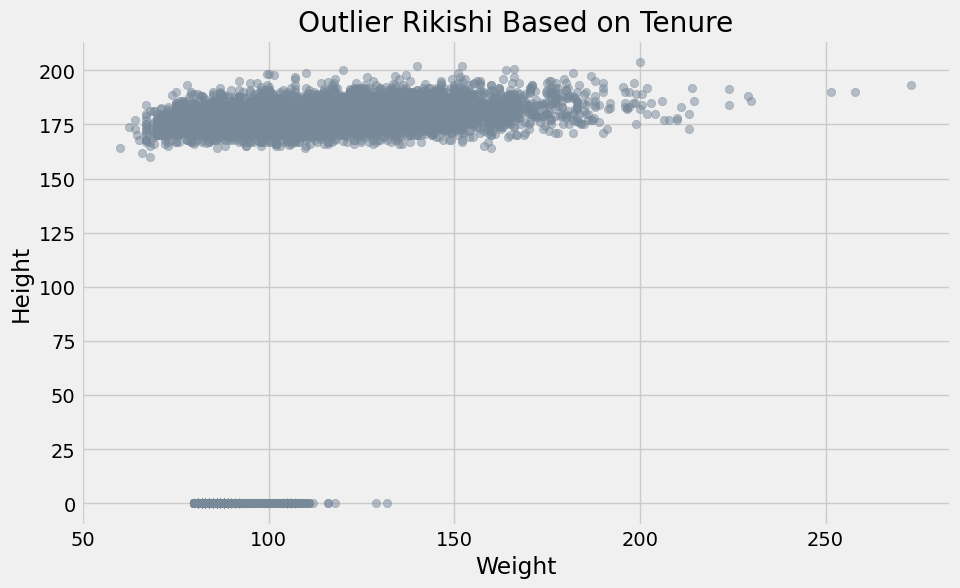

In [142]:
plt.figure(figsize=(10,6))

plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Outlier Rikishi Based on Tenure');

plt.scatter(x = sumo_df['weight'], y = sumo_df['height'], alpha = 0.5, color = 'lightslategrey');

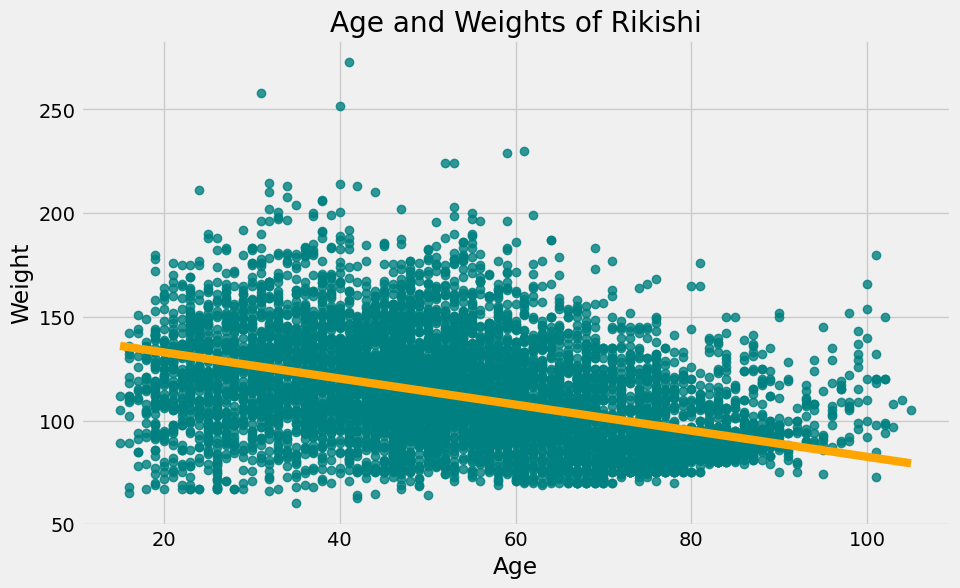

In [110]:
plt.figure(figsize=(10,6))

sns.regplot(data = sumo_df, x = 'age', y = 'weight', color = 'teal', line_kws = {'color':'orange'})

plt.xlabel('Age')
plt.ylabel('Weight')
plt.title('Age and Weights of Rikishi');

### Can re-use the missinghw_df to predict heights using its weight_predicted feature

### Multiple Linear Regression For Height Prediction

In [243]:
# Create X features and y value to predict

X = heightweight_df[['weight', 'age']]
y = heightweight_df['height']

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 24)

In [245]:
#Basline model as the mean
y_bar = np.mean(y_test)

#### Baseline model is 5.57cm or 2.19 inches

In [246]:
print(f'Null Mean Squared Error: {np.mean((y - y_bar)**2)}')
print(f'Null Root Mean Squared Error: {np.sqrt(np.mean((y - y_bar)**2))}')

Null Mean Squared Error: 31.034080576056827
Null Root Mean Squared Error: 5.570824048204792


In [250]:
height_lr_pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('height_lr',LinearRegression())
])

In [251]:
#Fit to training data
height_lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('sc', StandardScaler()), ('height_lr', LinearRegression())])

In [252]:
# Predict on test data
y_pred = height_lr_pipeline.predict(X_test)

#### Linear Regression Metrics

In [254]:
print(f'Training R-Squared Score: {height_lr_pipeline.score(X_train, y_train)}')
print(f'Testing R-Squred Score: {height_lr_pipeline.score(X_test, y_test)}')

Training R-Squared Score: 0.1442370389000205
Testing R-Squred Score: 0.1426568472386095


In [255]:
scores = cross_val_score(height_lr_pipeline, X_train, y_train, cv=5)

print("Train Cross-Validation Scores: ", scores)
print("Train Mean Cross-Validation Score: ", scores.mean())

Train Cross-Validation Scores:  [0.12992558 0.14675474 0.15762254 0.13408727 0.14940427]
Train Mean Cross-Validation Score:  0.14355887995001756


In [256]:
scores = cross_val_score(height_lr_pipeline, X_test, y_test, cv=5)

print("Test Cross-Validation Scores: ", scores)
print("Test Mean Cross-Validation Score: ", scores.mean())

Test Cross-Validation Scores:  [0.12430952 0.20312913 0.11368197 0.05348319 0.19266986]
Test Mean Cross-Validation Score:  0.1374547335760486


In [257]:
# Predictions on training data and calculating residuals
y_pred = height_lr_pipeline.predict(X_test)
resids = y_test - y_pred

#### RMSE for linear model is 5.16cm or 2.03 inches

In [258]:
print(f'Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred)}')
print(f'Root Mean Squared Error: {metrics.mean_squared_error(y_test, y_pred, squared = False)}')

Mean Squared Error: 26.613229778467428
Root Mean Squared Error: 5.158801195865899


### Random Forest


In [79]:
# height_rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [111]:
# Create X features and y value to predict

X = heightweight_df[['weight','age']]
y = heightweight_df['height']

In [112]:
# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 24)

In [121]:
#Basline model as the mean
y_bar = np.mean(y_test)
y_bar

178.40844471445934

In [113]:
# Instantiate Pipeline
rf_height_pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('height_rf', RandomForestRegressor(random_state = 24))
])

In [114]:
rf_height_params = {
    'height_rf__n_estimators': [50, 75, 100],
    'height_rf__max_depth': [10, 15, 20],
    'height_rf__min_samples_split': [100, 200, 300],
    'height_rf__min_samples_leaf':[7, 8 , 9],
}

In [117]:
height_rf_gridsearch = GridSearchCV(rf_height_pipeline, rf_height_params, scoring='r2', cv = 5)

In [118]:
height_rf_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('height_rf',
                                        RandomForestRegressor(random_state=24))]),
             param_grid={'height_rf__max_depth': [10, 15, 20],
                         'height_rf__min_samples_leaf': [7, 8, 9],
                         'height_rf__min_samples_split': [100, 200, 300],
                         'height_rf__n_estimators': [50, 75, 100]},
             scoring='r2')

In [119]:
best_cv_score = height_rf_gridsearch.best_score_
print(f'Best cross-validated score from GridSearchCV: {best_cv_score}')

Best cross-validated score from GridSearchCV: 0.15864092123087356
